# Computer Vision

We will implement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)-like deep, convolutional neural network (CNN) with PyTorch. We are going to use the CNN to classify flowers into the 102 categories.

The Python file consists of the following parts:

- Load and prepare data.
- Load a pretrained Alexnet in PyTorch.
- Set up transfer learning for flower classification problem
- Train the model
- Model performance monitoring and analysis with learning curve


#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data and unzip it. You should have three sets of data
data_dir = 'flowers/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [ ]:
!unzip -qq flowers.zip -d flowers

#### 1.2. Preview some images
Use PIL library to preview images

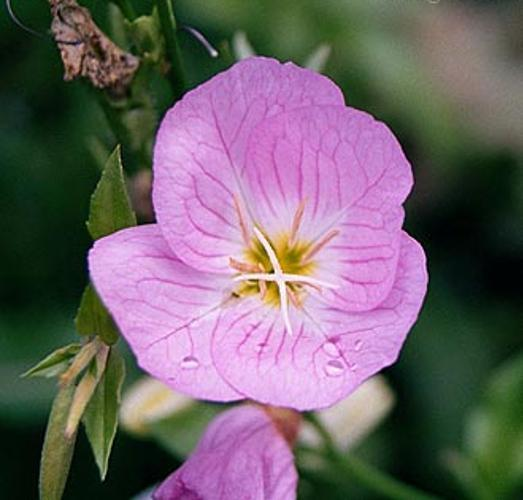

In [ ]:
from PIL import Image  #show one example of image

Image.open("flowers/flowers/train/1/image_06734.jpg")

#### 1.3. Data transformation and processing

In [ ]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])

class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  26 batches of training images; each with 256 images
We have  4 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown in

 https://bouzouitina-hamdi.medium.com/alexnet-imagenet-classification-with-deep-convolutional-neural-networks-d0210289746b

In [ ]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 186MB/s]


### 1.5. Update the classifier of the model to be compatible with our datasets

In [ ]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_flowers = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, hidden_units)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, number_of_flowers)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))


In [ ]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss() # this is the loss
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Then do the analysis for the validation only at the end of each training epochs
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = deepcopy(model.state_dict())

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

epoch 0 batch 0
training loss per batch 4.8448872566223145
training accuracy per batch 0.00390625
epoch 0 batch 5
training loss per batch 16.615631103515625
training accuracy per batch 0.01953125
epoch 0 batch 10
training loss per batch 10.858120918273926
training accuracy per batch 0.1015625
epoch 0 batch 15
training loss per batch 4.404170513153076
training accuracy per batch 0.1640625
epoch 0 batch 20
training loss per batch 3.3366217613220215
training accuracy per batch 0.25390625
epoch 0 batch 25
training loss per batch 3.241539716720581
training accuracy per batch 0.2565789520740509
epoch 0 summary
avg training loss per epoch 8.624430528053871
avg training accuracy per epoch 0.13862443084900195
avg validation loss per epoch 2.2892059087753296
avg validation accuracy per epoch 0.47230468690395355

epoch 1 batch 0
training loss per batch 2.8207123279571533
training accuracy per batch 0.34375
epoch 1 batch 5
training loss per batch 2.5588021278381348
training accuracy per batch 0.35

Report the best model's validation accuracy*
best_validation_accuracy = 0.9057812541723251 (epoch 29)

### 1.7. Draw learning curves

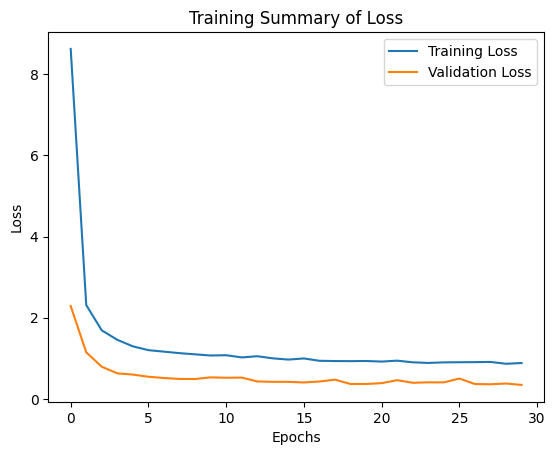

In [ ]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

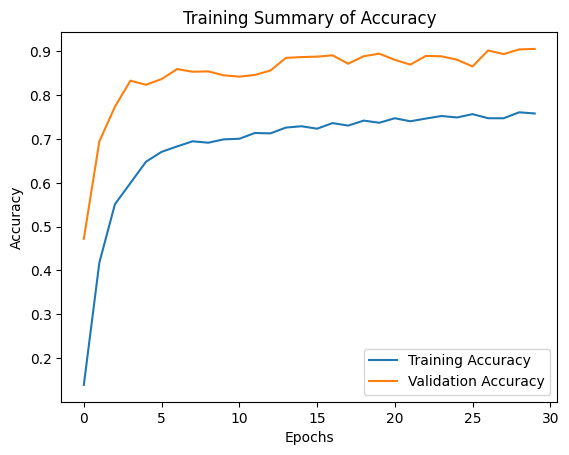

In [ ]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### *Brief description of the plots*

- Training Summary of Loss:

The training loss is represented by the blue curve, which gets smaller as the number of epochs increases.  This indicates that the model is improving its prediction skills through learning. At the first epoch, the loss is relatively high before declining. Between the 10th-15th epoch, it stabilizes. The training loss begins at a value higher than 8, which is quite high. After the first several epochs, it decreases to about 1.

The validation loss is represented by the orange curve. After the first epoch or two, the validation loss also decreases.  After peaking at 2, the validation loss rapidly decreases in the initial epochs. It settles between 0.4 and 0.6.

- Training Summary of Accuracy:

The training accuracy is represented by the blue curve. The accuracy increases gradually as the number of epochs increases from a low starting point of about 0.1. At roughly epoch 20, it stabilizes at 0.7 with just little variations.

The validation accuracy is represented by the orange curve and it starts at 0.5 (which is higher than training accuracy) and continues this trend with a rapid increase of 0.8 seen at epoch 2. It varies from 0.8 to 0.9 as the number of epochs increases.

The model appears to be learning effectively based on both the accuracy and loss curves. It is evident that the model is not overfitting because it performs better on validation data than training data.

### 1.8. Predict on the test data with the best model so far

In [ ]:
# Predict on the test data

# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

for images, labels in dataloaders['testing']:
    images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU if available
    log_ps = model(images)  # Forward pass
    ps = torch.exp(log_ps)  # Get probabilities
    top_ps, top_class = ps.topk(1, dim=1)  # Get top predicted probabilities and classes
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)  # Check for matches
    test_accuracy += matches.mean()  # Calculates sum of mean of the matches for accuracy
    predictions.extend(top_class.cpu().numpy())  # Store predictions
    label_data.extend(labels.cpu().numpy())  # Store actual labels

    # Try to do similar things as validation to get the test accuracy
    # You also need to store the predictions and labels for all the test data, which will be used later
    # you could save them in predictions and label_data
print('Test Accuracy:', test_accuracy.item() / test_len)

Test Accuracy: 0.8356502652168274


### *Report the test accuracy with the best model*

The test accuracy with the best model is 0.8356502652168274

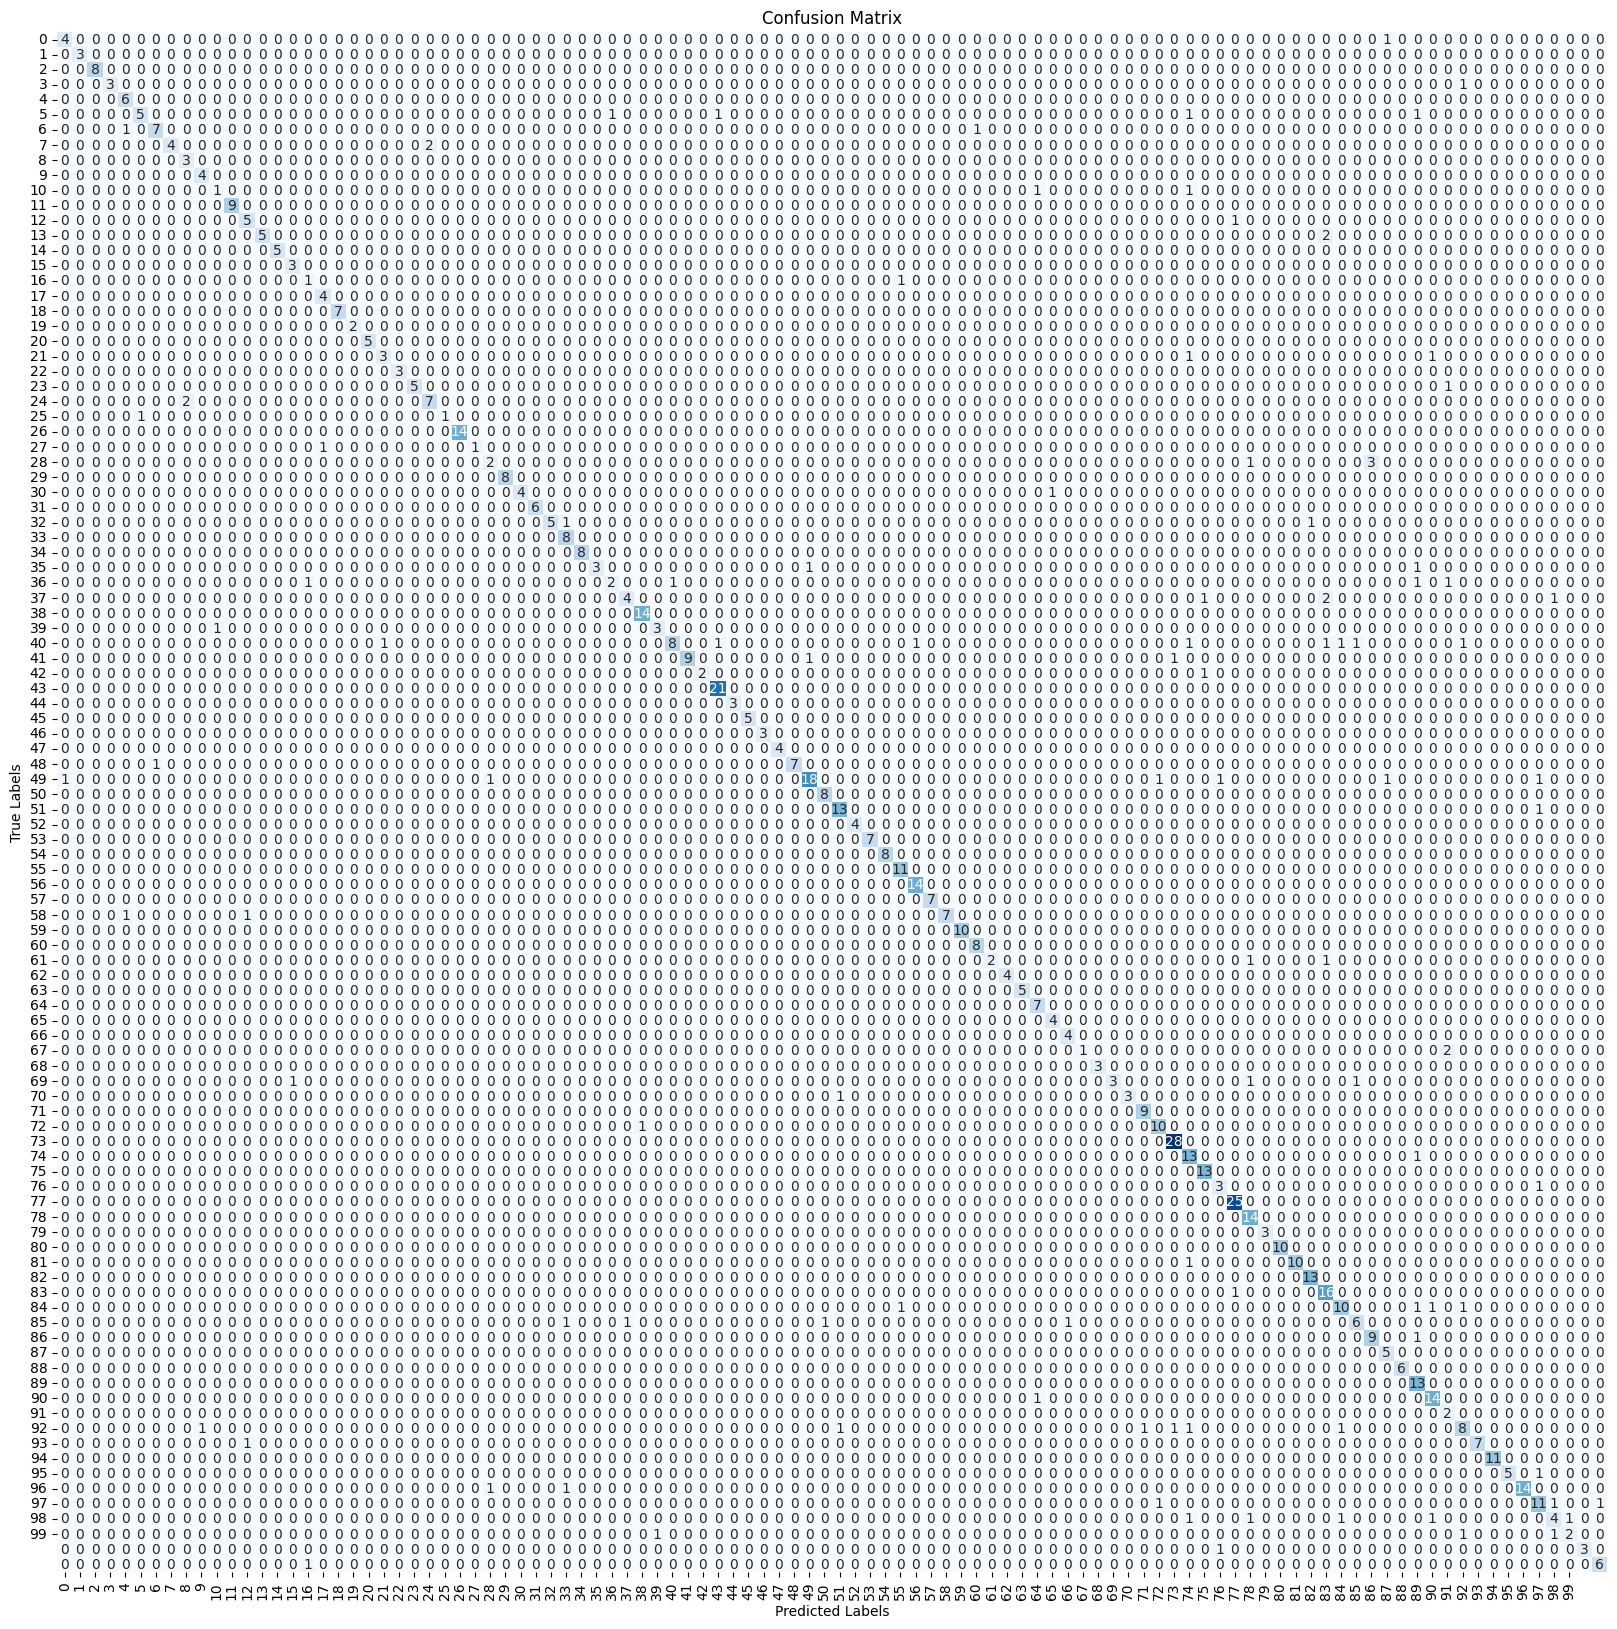

normalized confusion matrix
[[0.8        0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.4        0.         0.        ]
 [0.         0.         0.         ... 0.         0.75       0.        ]
 [0.         0.         0.         ... 0.         0.         0.85714286]]


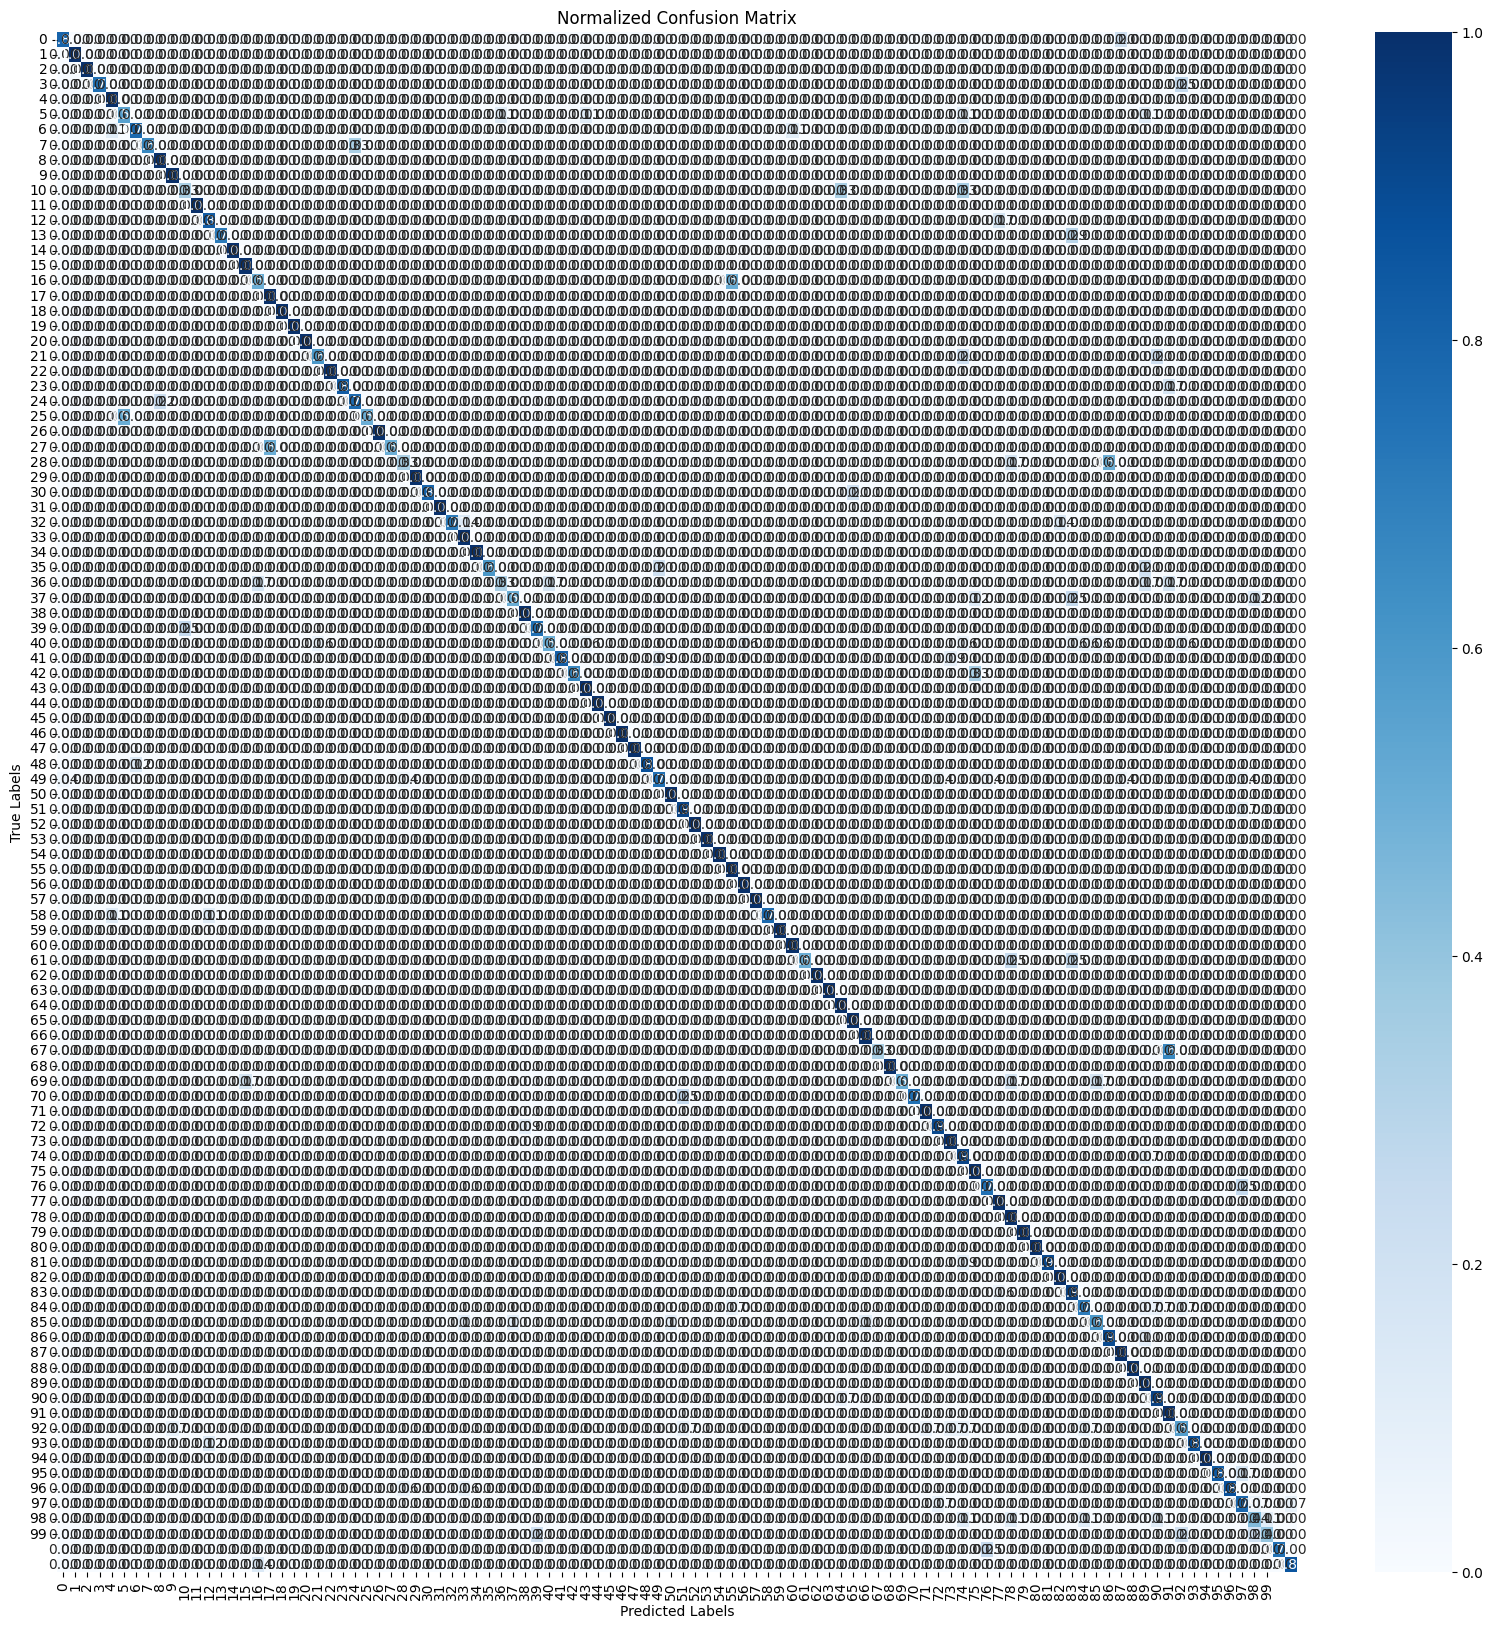

In [ ]:
# Plotting the confusion matrix
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=range(100), yticklabels=range(100))  # Adjust the xticklabels and yticklabels as needed
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Normalized confusion matrix
print('normalized confusion matrix')
ncf = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]  # Normalize by row
print(ncf)
plt.figure(figsize=(20, 20))
sns.heatmap(ncf, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=range(100), yticklabels=range(100))  # Adjust the xticklabels and yticklabels as needed
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
